In [28]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns



# plt.rcParams["mathtext.fontset"] = "stix"
# plt.rcParams["font.family"] = "STIXGeneral"
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.sans-serif'] = ['SimHei']
fontpath = 'FandolSong-Regular.otf'
font = fm.FontProperties(fname=fontpath)
sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
},font=font.get_name())
plt.rcParams['axes.unicode_minus'] = False

sys.path.append("..")
from swarmalatorlib.template import Swarmalators2D

[0.99448837 1.11693822 0.99662982]


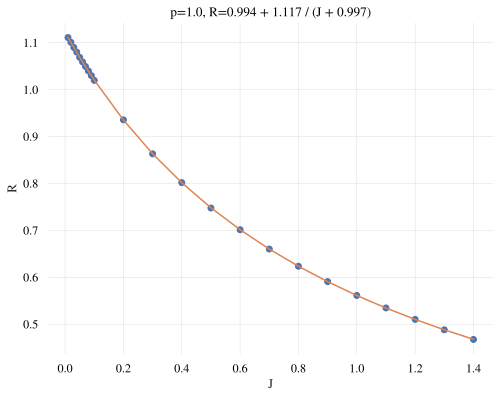

In [19]:
Jrange = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.5, 0.1),
])
Rs = pd.read_csv("含相位半径.csv", index_col=0)
Rs = Rs[Rs.index <= Jrange.max()]

p = 1
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return (b / (a + x)) ** c

R = Rs["1000"].values

popt, pcov = curve_fit(func, Jrange, R, maxfev=5000)
print(popt) 

plt.figure(figsize=(8, 6))
plt.plot(Jrange, R, "o", label="data")
plt.plot(Jrange, func(Jrange, *popt), label="fit")
plt.xlabel("J")
plt.ylabel("R")
plt.title(f"p={p:.1f}, R={popt[0]:.3f} + {popt[1]:.3f} / (J + {popt[2]:.3f})")
plt.savefig(f"radiusFitRaw.png", dpi=200, bbox_inches="tight")

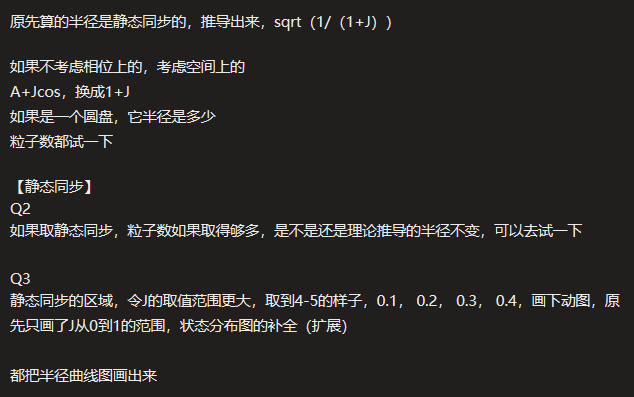

In [2]:
from main import Strogatz2017, Strogatz2017Fix

In [4]:
model = Strogatz2017(agentsNum=1000, dt=0.1, K=-0.1, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False)

In [6]:
for model in [
    Strogatz2017(agentsNum=1000, dt=0.1, K=1, J=0.1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-1, J=0.1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=0, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-0.1, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-0.75, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False)
]:
    model.run(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

data/Strogatz2017_a1000_K0_J1.00.h5 already exists
data/Strogatz2017_a1000_K-0.1_J1.00.h5 already exists


  0%|          | 0/2000 [00:00<?, ?it/s]

In [4]:
model.run(2000)

data/Strogatz2017_a1000_K-0.1_J1.00.h5 already exists


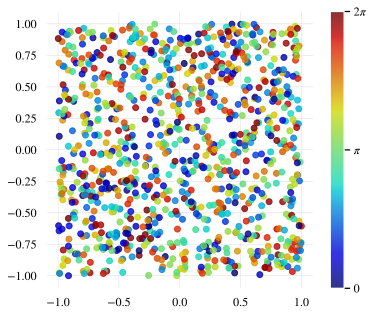

In [5]:
model.plot()

In [ ]:
models = [
    Strogatz2017(agentsNum=1000, dt=0.1, K=1, J=0.1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-1, J=0.1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=0, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-0.1, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False),
    Strogatz2017(agentsNum=1000, dt=0.1, K=-0.75, J=1, randomSeed=0, tqdm=True, savePath="data", shotsnaps=5, overWrite=False)
]

def plot_last(ax: plt.Axes, model: Swarmalators2D):
    targetPath = f"{model.savePath}/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)

    positionX = totalPositionX[-1]
    phaseTheta = totalPhaseTheta[-1]

    sc = ax.scatter(positionX[:, 0], positionX[:, 1],
                c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)
    
    # cbar = plt.colorbar(sc, ticks=[0, np.pi, 2*np.pi], ax=ax)
    # cbar.ax.set_ylim(0, 2*np.pi)
    # cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])

for model in models:
    plot_last(plt.gca(), model)
    
    # plt.savefig(f"{model}.png", dpi=200, bbox_inches="tight")

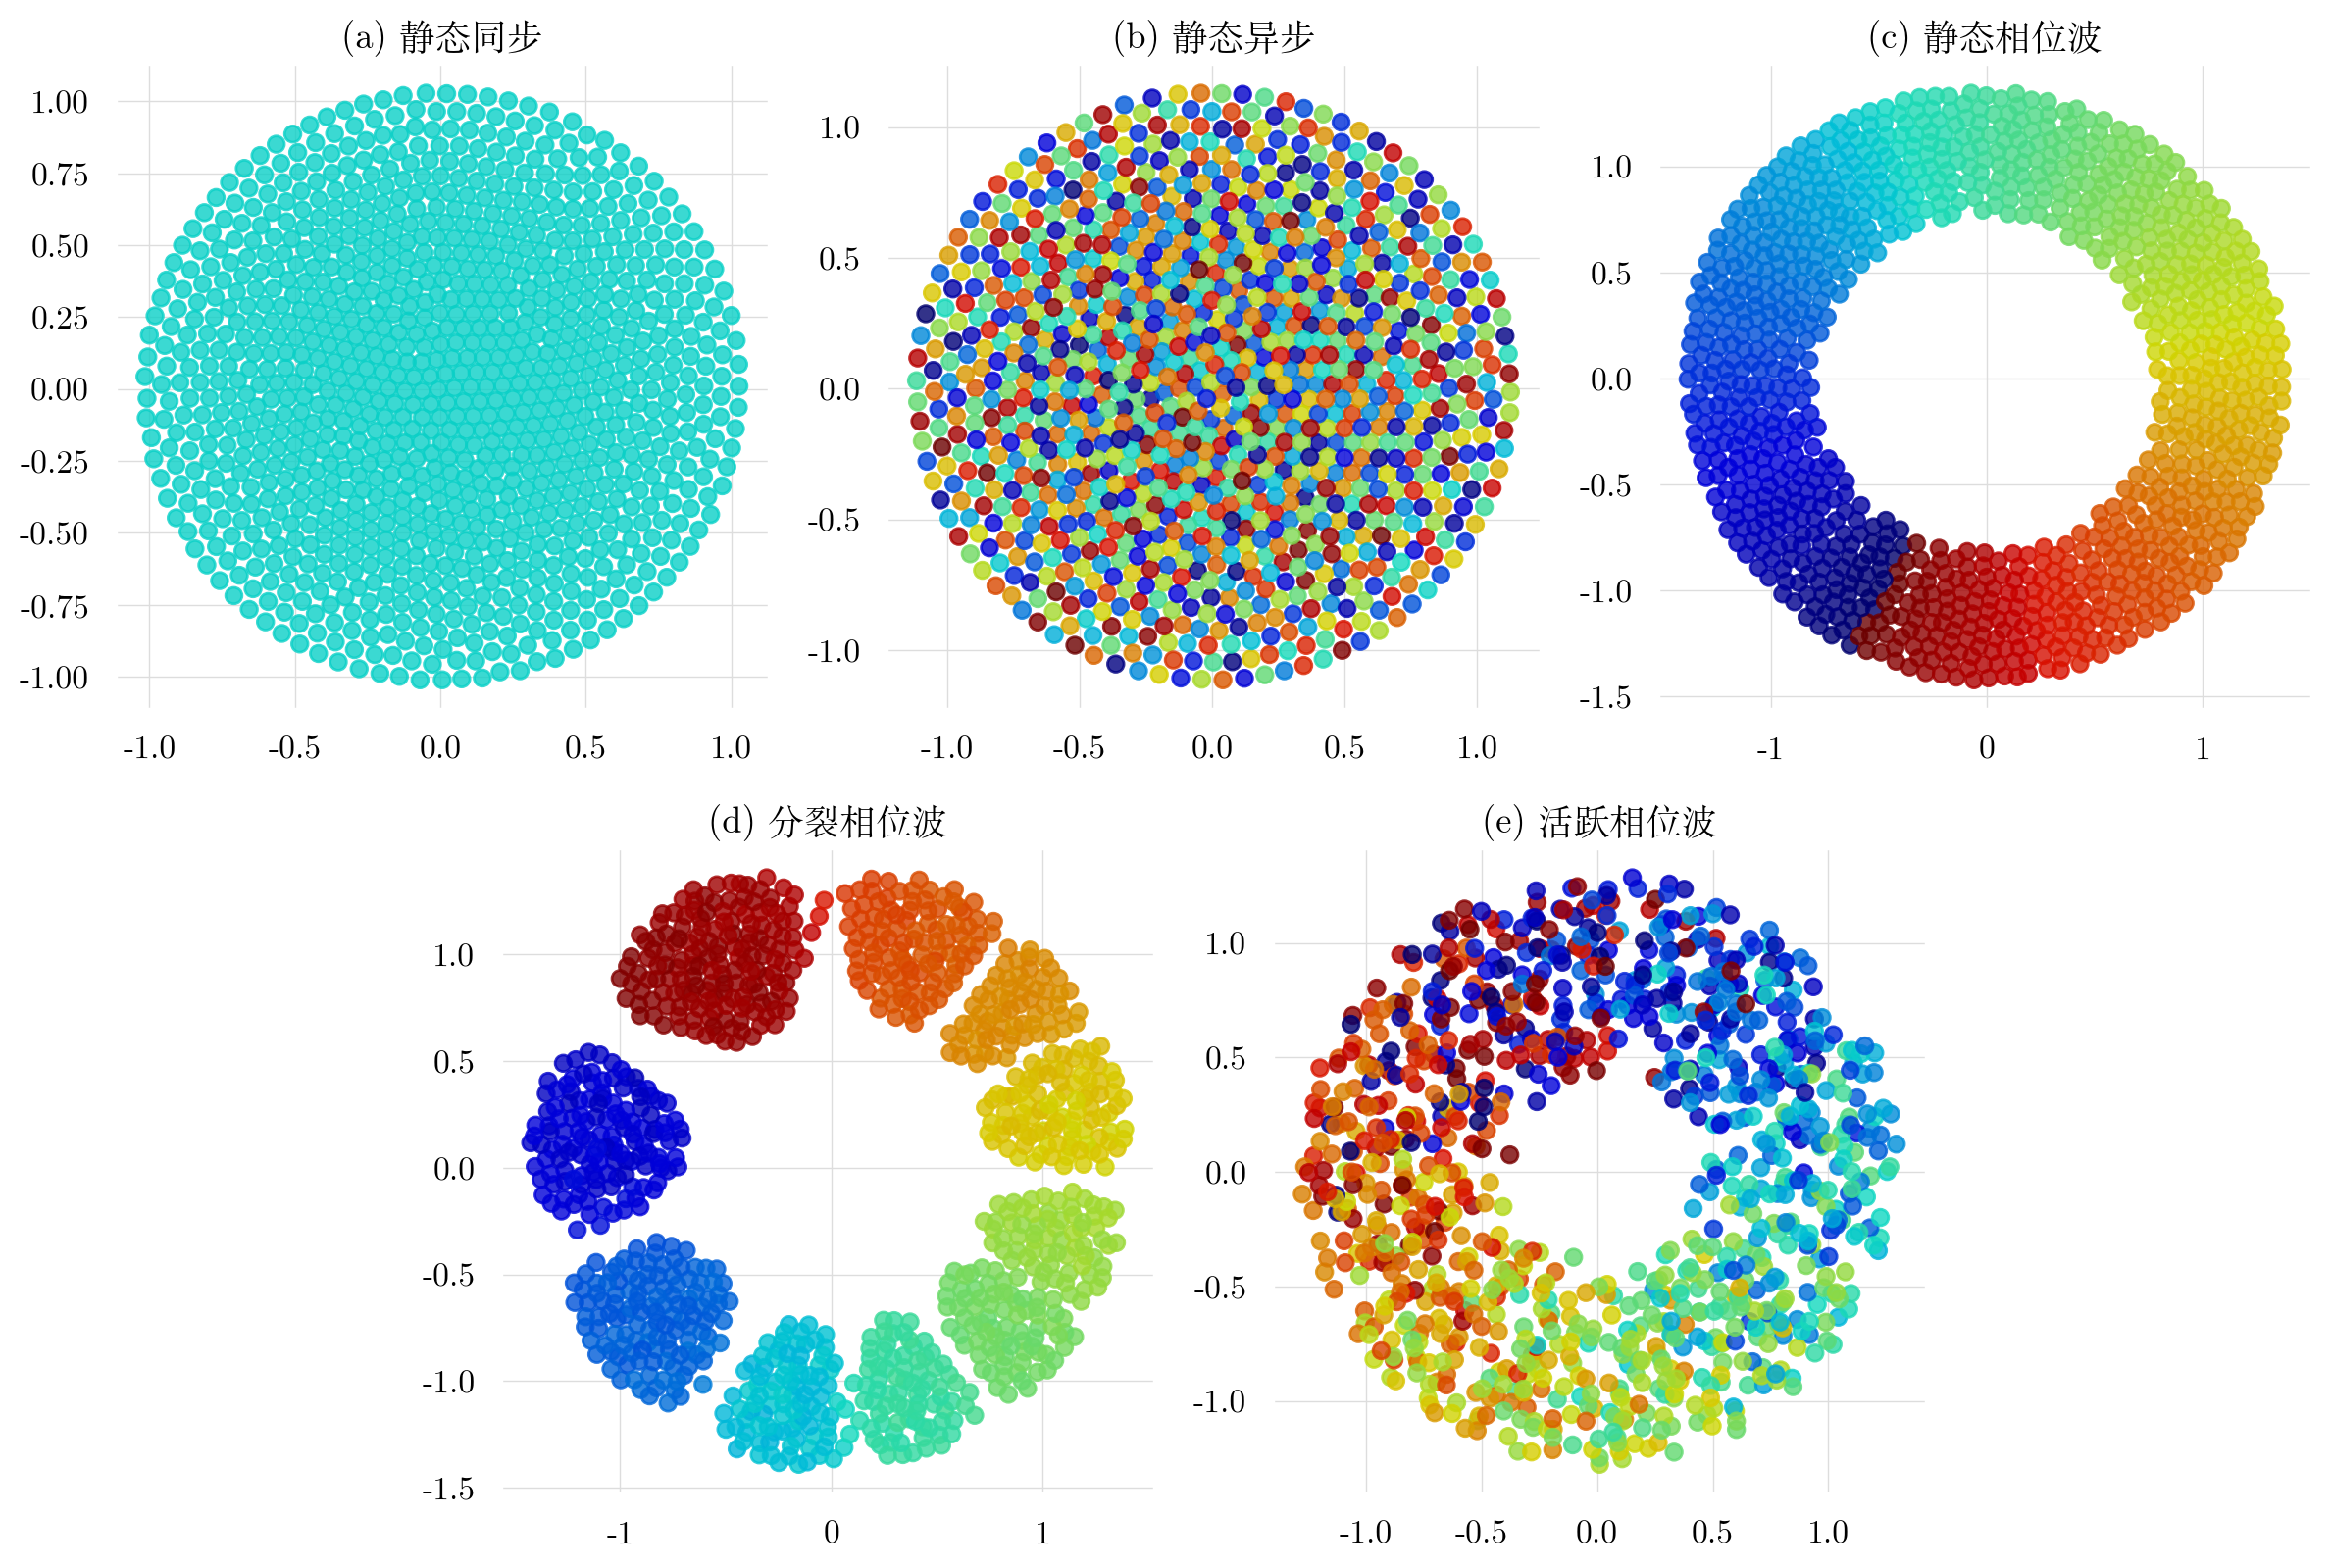

In [34]:
fig = plt.figure(figsize=(12, 8.2))

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
axs = [ax1, ax2, ax3, ax4, ax5]
titles = [
    "(a) 静态同步",
    "(b) 静态异步",
    "(c) 静态相位波",
    "(d) 分裂相位波",
    "(e) 活跃相位波"
]

for idx in range(5):
    plot_last(axs[idx], models[idx])
    axs[idx].set_title(titles[idx])

plt.tight_layout()
plt.savefig("last.png", dpi=200, bbox_inches="tight")
plt.show()

In [8]:
positionX = model.positionX
centor = positionX.mean(axis=0)
distance = np.linalg.norm(positionX - centor, axis=1)
np.mean(np.sort(distance)[-int(model.agentsNum * 0.01):])

0.5623203202935109

In [15]:
max(((positionX - centor)[:, 0] ** 2 + (positionX - centor)[:, 1] ** 2) ** 0.5)

0.5630585870802425

In [7]:
from itertools import product

Jrange = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1),
    np.arange(1, 11, 1)
])
agentsNumRange = np.arange(1000, 5001, 1000)


models = [
    Strogatz2017(agentsNum=agentsNum, dt=0.1, K=1, J=J, 
                 fixSpiralPhaseCoupling=True, randomSeed=randomSeed, 
                 tqdm=True, savePath="data", shotsnaps=1)
    for J, agentsNum in tqdm(product(Jrange, agentsNumRange), total=len(Jrange) * len(agentsNumRange))
]

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
def run_model(model):
    model.run(2000)

with Pool(40) as p:
    p.map(run_model, models)

  0%|          | 0/1001 [00:00<?, ?it/s]

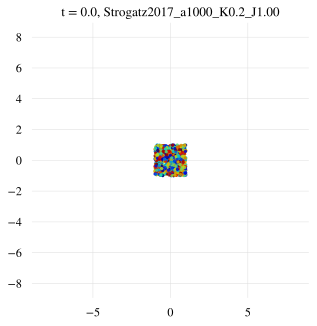

In [8]:
targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)

positionLim = np.max(np.abs(totalPositionX)) * 1.1

# TNum = 100
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]

    # fig.clear()
    ax.clear()
    ax.scatter(positionX[:, 0], positionX[:, 1], s=5, c=phaseTheta, cmap=new_cmap, vmin=0, vmax=2 * np.pi, alpha=0.8)
    ax.set_xlim(-positionLim, positionLim)
    ax.set_ylim(-positionLim, positionLim)
    ax.set_title(f"t = {i * model.dt:.1f}, {model}")

fig, ax = plt.subplots(figsize=(5, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
ani.save(f"{model}.mp4", dpi=200)

In [7]:
positionLim

nan